# PREPROCESS

In [35]:
from PIL import Image
from glob import glob
from tqdm import tqdm
import os

from multiprocessing import Pool

In [71]:
OUTPUT_SIZE = (512, 512)
OUTPUT_DIR = '../input/images_resize/'

os.makedirs(OUTPUT_DIR, exist_ok=True)
pathes = glob(os.path.join('../input/jpeg/train/', '*.jpg'))

print(f'{len(pathes)} images found')

33126 images found


Get resolutions

In [74]:
%%time
import numpy as np
import pandas as pd


def get_res(img_path: str):
    img = Image.open(img_path)
    return [img.height, img.width]

resolutions = list(map(get_res, pathes))

unique_resolutions = [list(x) for x in set(tuple(x) for x in resolutions)]
unique_resolutions

CPU times: user 1.19 s, sys: 123 ms, total: 1.31 s
Wall time: 1.32 s


[[1773, 1773],
 [2029, 2029],
 [1803, 1803],
 [1781, 1781],
 [1811, 1811],
 [756, 1066],
 [2043, 2043],
 [2431, 2431],
 [1793, 1793],
 [1753, 1753],
 [2215, 2215],
 [2087, 2087],
 [3024, 4032],
 [2000, 3008],
 [1765, 1765],
 [1757, 1757],
 [2397, 2397],
 [1955, 1955],
 [2295, 2295],
 [2057, 2057],
 [1783, 1783],
 [2017, 2017],
 [1967, 1967],
 [1761, 1761],
 [1745, 1745],
 [1711, 1711],
 [5184, 3456],
 [2317, 2317],
 [1771, 1771],
 [2291, 2291],
 [1779, 1779],
 [3338, 4332],
 [2169, 2169],
 [2375, 2375],
 [2439, 2439],
 [1053, 1872],
 [2237, 2237],
 [1969, 1969],
 [2329, 2329],
 [1767, 1767],
 [3264, 2448],
 [4288, 2848],
 [1755, 1755],
 [1763, 1763],
 [1943, 1943],
 [1897, 1897],
 [2217, 2217],
 [5185, 3457],
 [1759, 1759],
 [1775, 1775],
 [3456, 5184],
 [2229, 2229],
 [2421, 2421],
 [2165, 2165],
 [2187, 2187],
 [2196, 2196],
 [4000, 6000],
 [480, 640],
 [1979, 1979],
 [1936, 2592],
 [1857, 1857],
 [1983, 1983],
 [2592, 3888],
 [1993, 1993],
 [3312, 4416],
 [3368, 6000],
 [2592, 3872]

Process single image

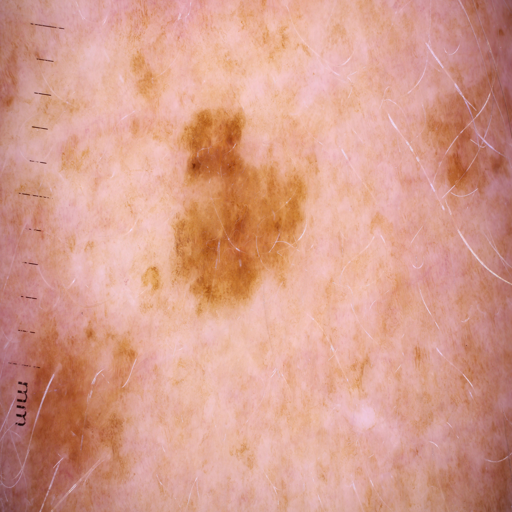

In [75]:
img = Image.open(pathes[0])
img.resize(OUTPUT_SIZE, Image.BICUBIC)

Process the whole dataset with progress bar

In [34]:
%%time

def resize_img(img_path: str):
    img = Image.open(img_path)
    img = img.resize(OUTPUT_SIZE, Image.BICUBIC)
    img.save(os.path.join(OUTPUT_DIR, os.path.basename(img_path)))


with Pool(8) as p:
    list(tqdm(p.imap(resize_img, pathes), total=len(pathes)))

100%|██████████| 1000/1000 [00:08<00:00, 124.18it/s]

CPU times: user 42.3 s, sys: 793 ms, total: 43.1 s
Wall time: 8.12 s


# CREATE FOLDS

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [82]:
FEATURES = 'image_name'
TARGET = 'target'

In [100]:
df = pd.read_csv('../input/train.csv')
df['kfold'] = np.nan
# df = df.sample(frac=1).reset_index(drop=True)

X = df[FEATURES].values
y = df[TARGET].values

In [101]:
valid=10
skf = StratifiedKFold(n_splits=int(100/valid), random_state=42)

for fold, (train, valid) in enumerate(skf.split(X, y)):
    if fold == 0:
        df.loc[valid, 'kfold'] = -1
    else:
        break

df_valid = df[df['kfold'] == -1].reset_index(drop=True)

In [102]:
df_train = df[df['kfold'].isnull()].reset_index(drop=True)
X = df_train[FEATURES].values
y = df_train[TARGET].values

skf = StratifiedKFold(n_splits=5, random_state=42)
for fold, (train, valid) in enumerate(skf.split(X, y)):
    df_train.loc[valid, 'kfold'] = fold

df = pd.concat([df_train, df_valid])
df.reset_index(drop=True, inplace=True)
print('Number of samples per class:')
print(df['kfold'].value_counts(dropna=False))
print('\nClass "-1" is for validation')

Number of samples per class:
 1.0    5963
 0.0    5963
 3.0    5962
 4.0    5962
 2.0    5962
-1.0    3314
Name: kfold, dtype: int64

Class "-1" is for validation


# DATASET

In [16]:
%matplotlib inline

In [17]:
INPUT_DIR = '../input/'

In [19]:
from os.path import join
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [33]:
class MelanomaDataset(Dataset):
    def __init__(self, df, input_dir, transforms=None):
        self.df = df
        self.input_dir = input_dir
        self.transforms=transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        image_src = join(self.input_dir, 'images_resized/', self.df.loc[idx, 'image_name'] + '.jpg')
        image = cv2.imread(image_src, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.loc[idx, 'target']
        label = label.astype(np.int8).reshape(-1,)
        
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image, label

In [27]:
transforms_train = A.Compose([
    # Rigid aug
    A.OneOf([
        A.ShiftScaleRotate(rotate_limit=1.0, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
    ], p=0.5),


    # Pixels aug
    A.OneOf([
        A.HueSaturationValue(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.RandomGamma(p=0.3)
    ], p=0.3),
    
    A.OneOf([
        A.IAAEmboss(p=1.0),
        A.IAASharpen(p=1.0),
        A.Blur(blur_limit=5, p=1.0),
        A.CLAHE(p=1.0)
    ], p=0.3),


    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

transforms_valid = A.Compose([
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

In [28]:
train_df = pd.read_csv(join(INPUT_DIR, 'train.csv'))
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [29]:
submission_df = pd.read_csv(join(INPUT_DIR + 'sample_submission.csv'))
submission_df.iloc[:, 1:] = 0

submission_df.head()

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


In [34]:
BATCH_SIZE = 64

dataset_test = MelanomaDataset(submission_df, INPUT_DIR, transforms=transforms_valid)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)

In [35]:
dataset = MelanomaDataset(train_df, INPUT_DIR)

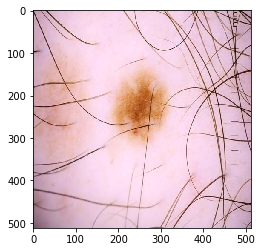

In [36]:
import matplotlib.pyplot as plt
plt.imshow(dataset[25][0])

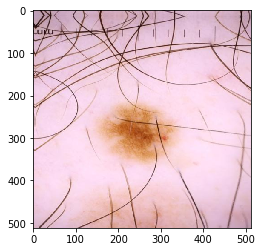

In [37]:
plt.imshow(A.ShiftScaleRotate(rotate_limit=100, p=1)(image=dataset[25][0])['image'])

In [38]:
from dataset import MelanomaDataset

In [40]:
dataset = MelanomaDataset(train_df, INPUT_DIR)

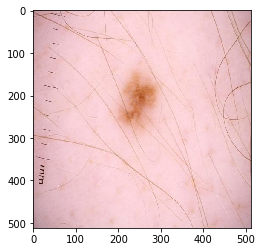

In [41]:
import matplotlib.pyplot as plt
plt.imshow(dataset[35][0])

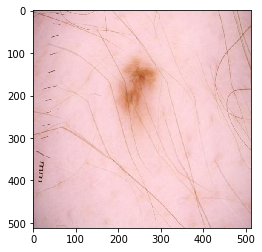

In [42]:
plt.imshow(A.IAAPiecewiseAffine(p=1)(image=dataset[35][0])['image'])

# Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from efficientnet_pytorch import EfficientNet

In [4]:
# model = torchvision.models.resnet18(pretrained=True)
model = EfficientNet.from_name('efficientnet-b5')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 4)